<a href="https://colab.research.google.com/github/davidsonsantana89/futebol-simulacao/blob/main/dass_simulacao_campeonato_aplicacao_serie_b_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este é o código refatorado do script encontrado [aqui](https://colab.research.google.com/drive/1r77Saxke_Xs2KFA9WC0NwmxP2SqQNdPL?authuser=3)

## BIBLIOTECAS UTILIZADAS NESTE PROJETO

In [1]:
# bibliotecas a serem utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import poisson,skellam
from tqdm.notebook import tqdm_notebook
import datetime
plt.style.use('ggplot')

## FUNÇÕES UTILIZADAS NESSE PROJETO

In [ ]:
def MediaGolsTime(serie): # determina a média de gols marcados
    media = np.mean(serie)

    return media


def PontosJogos(dataframe): # determina os pontos obtidos por mandante e visitante, respectivamente
    dataframe['points_home'] = dataframe.apply(lambda row: 3 if (row['FTHG'] > row['FTAG']) else 1 if (row['FTHG'] == row['FTAG']) else 0, axis=1)
    dataframe['points_away'] = dataframe.apply(lambda row: 3 if (row['FTHG'] < row['FTAG']) else 1 if (row['FTHG'] == row['FTAG']) else 0, axis=1)

    return dataframe


def DefineVitoria(dataframe): # determina se foi vitoria ou não para  mandante e visitante, respectivamente
    dataframe['vitoria_home'] = dataframe.apply(lambda row: 1 if (row['FTHG'] > row['FTAG']) else 0, axis=1)
    dataframe['vitoria_away'] = dataframe.apply(lambda row: 1 if (row['FTHG'] < row['FTAG']) else 0, axis=1)

    return dataframe

def GolsMarcadosAteHoje(results, fixtures, registro): # determina o total de gols marcados pelo  mandante e visitante, respectivamente, até a rodada atual (registro)
    gols_home = results[(results['home'] == fixtures.iloc[registro, 1]) & (results['data'] <= fixtures.iloc[registro, 0])]['FTHG'].sum()
    gols_away = results[(results['away'] == fixtures.iloc[registro, 2]) & (results['data'] <= fixtures.iloc[registro, 0])]['FTAG'].sum()

    return gols_home, gols_away

def GolsSofridosAteHoje(results, fixtures, registro): # determina o total de gols sofridos pelo  mandante e visitante, respectivamente, até a rodada atual (registro)
    gols_sofridos_home = results[(results['home'] == fixtures.iloc[registro, 1]) & (results['data'] <= fixtures.iloc[registro, 0])]['FTAG'].sum()
    gols_sofridos_away = results[(results['away'] == fixtures.iloc[registro, 2]) & (results['data'] <= fixtures.iloc[registro, 0])]['FTHG'].sum()

    return gols_sofridos_home, gols_sofridos_away


def VetorMandante(vetor_jogo_camp_passado, results, fixtures, registro): # código para determinar o vetor do mandante para a partida atual
    gol_h = GolsMarcadosAteHoje(results, fixtures, registro)[0]
    gol_a = GolsSofridosAteHoje(results, fixtures, registro)[0]

    vetor_h, vetor_a = vetor_jogo_camp_passado

    gols_feitos_mandante = sum([vetor_h, gol_h])/(results[results['home'] == fixtures.iloc[i, 1]].shape[0] + 1)
    gols_sofridos_mandante = sum([vetor_a, gol_a])/(results[results['home'] == fixtures.iloc[i, 1]].shape[0] + 1)

    vetor_mandante = np.array([gols_feitos_mandante, gols_sofridos_mandante])

    return vetor_mandante


def VetorVisitante(vetor_jogo_camp_passado, results, fixtures, registro): # código para determinar o vetor do visitante para a partida atual
    gol_a = GolsMarcadosAteHoje(results, fixtures, registro)[1]
    gol_h = GolsSofridosAteHoje(results, fixtures, registro)[1]

    vetor_h, vetor_a = vetor_jogo_camp_passado

    gols_feitos_visitante = sum([vetor_a, gol_a])/(results[results['away'] == fixtures.iloc[i, 1]].shape[0] + 1)
    gols_sofridos_visitante = sum([vetor_h, gol_h])/(results[results['away'] == fixtures.iloc[i, 1]].shape[0] + 1)

    vetor_visitante = np.array([gols_feitos_visitante, gols_sofridos_visitante])

    return vetor_visitante


def VetorJogo(vetor_jogo_camp_passado, results, fixtures, registro): # código para determinar o vetor do jogo atual

    gols_feitos_mandante, gols_sofridos_mandante = VetorMandante(vetor_jogo_camp_passado, results, fixtures, registro)

    gols_feitos_visitante, gols_sofridos_visitante = VetorVisitante(vetor_jogo_camp_passado, results, fixtures, registro)

    media_mandante = np.array([gols_feitos_mandante, gols_sofridos_visitante]).mean()
    media_visitante = np.array([gols_feitos_visitante, gols_sofridos_mandante]).mean()

    vetor_jogo = np.array([media_mandante, media_visitante])

    return vetor_jogo


# função que calcula as probabilidades acumuladas de Poisson
def PoissonAcumulada(media_ocorrencias, num_ocorrencias=6):
    distribuicao_poisson = np.array([poisson.pmf(k, media_ocorrencias) for k in range(num_ocorrencias)])
    distr_poisson_acum = np.cumsum(distribuicao_poisson)

    return distr_poisson_acum


def NumGolsMarcados(media_ocorrencias): # Função que prediz o número de gols marcados por uma equipe
    lista = PoissonAcumulada(media_ocorrencias, num_ocorrencias=6)

    x = np.random.rand()
    num_gol = np.searchsorted(lista, x)
    return num_gol


def PontosJogo(gols_home, gols_away):

    if gols_home > gols_away:
        pontos_home, pontos_away = [3, 0]
    elif gols_home == gols_away:
        pontos_home, pontos_away = [1, 1]
    else:
        pontos_home, pontos_away = [0, 3]

    return pontos_home, pontos_away


def GolsSeason(dataframe, time):
    # cálculo de gols pró
    gols_pro_home = dataframe[dataframe['home'] == time]['FTHG'].sum()
    gols_pro_away = dataframe[dataframe['away'] == time]['FTAG'].sum()
    gols_pro = gols_pro_home + gols_pro_away

    # cálculo de gols contra
    gols_contra_home = dataframe[dataframe['home'] == time]['FTAG'].sum()
    gols_contra_away = dataframe[dataframe['away'] == time]['FTHG'].sum()
    gols_contra = gols_contra_home + gols_contra_away

    return (gols_pro, gols_contra)


def SaldoGols(dataframe, time):
    pro, contra = GolsSeason(dataframe, time)
    diff = pro - contra

    return diff


def NumVitorias(dataframe, time):
    vitorias_home = dataframe[dataframe['home'] == time]['vitoria_home'].sum()
    vitorias_away = dataframe[dataframe['away'] == time]['vitoria_away'].sum()
    soma_vitorias = vitorias_home + vitorias_away

    return soma_vitorias


def NumPontos(dataframe, time):
    pontos_home = dataframe[dataframe['home'] == time]['points_home'].sum()
    pontos_away = dataframe[dataframe['away'] == time]['points_away'].sum()
    soma_pontos = pontos_home + pontos_away

    return soma_pontos


def ClassificacaoSeason(dataframe):
    equipes = dataframe['home'].unique()

    lista_classificacao = [(time, NumPontos(dataframe, time),
                            NumVitorias(dataframe, time),
                            SaldoGols(dataframe, time),
                            GolsSeason(dataframe, time)[0]) for time in equipes]

    df_classificacao = pd.DataFrame(lista_classificacao, columns=['equipe',
                                                                  'pontos',
                                                                  'num_vitorias',
                                                                  'gols_pro',
                                                                  'diff'])
    df_classificacao = df_classificacao.sort_values(['pontos',
                                                     'num_vitorias',
                                                     'diff', 'gols_pro'], ascending=False).reset_index(drop=True)
    df_classificacao.insert(0, 'rank', range(1, 21))

    return df_classificacao


############# FUNÇÕES PARA AS PREVISÕES ################

#CHANCE DE REBAIXAMENTO
def Rebaixamento(equipes):
    rebaixamento =[]

    for equipe in equipes:
        a = simulacao[simulacao['equipe'] == equipe]
        a_posicao, a_chances_fn = np.unique(a['rank'], return_counts=True)
        a_chances_fr = [round(i/sum(a_chances_fn), 4) for i in a_chances_fn]
        b = pd.DataFrame({'POSIÇÃO':a_posicao, 'CHANCE':a_chances_fr})
        c = b.loc[b['POSIÇÃO']>16]['CHANCE'].sum()
        rebaixamento.append((equipe, c))

    tabela_rebaixamento = pd.DataFrame(rebaixamento, columns = ['EQUIPE', 'CHANCE'])
    tabela_rebaixamento = tabela_rebaixamento.sort_values('CHANCE', ascending=False).reset_index(drop=True)
    tabela_rebaixamento.index = tabela_rebaixamento.index.map(lambda x: x + 1)

    # return tabela_rebaixamento.head().style.format({'CHANCE': '{:.2%}'})
    return tabela_rebaixamento


# CHANCE DE acesso
def Acesso(equipes):
    acesso =[]

    for equipe in equipes:
        x = simulacao[simulacao['equipe'] == equipe]
        x_posicao, x_chances_fn = np.unique(x['rank'], return_counts=True)
        x_chances_fr = [round(i/sum(x_chances_fn), 3) for i in x_chances_fn]
        y = pd.DataFrame({'POSIÇÃO':x_posicao, 'CHANCE':x_chances_fr})
        z = y.loc[y['POSIÇÃO']<5]['CHANCE'].sum()
        acesso.append([equipe, z])

    tabela_acesso = pd.DataFrame(acesso, columns = ['EQUIPE', 'CHANCE'])
    tabela_acesso = tabela_acesso.sort_values('CHANCE', ascending=False).reset_index(drop=True)
    tabela_acesso.index = tabela_acesso.index.map(lambda x: x + 1)

    # return tabela_acesso.head().style.format({'CHANCE': '{:.2%}'})
    return tabela_acesso


# CHANCE DE TÍTULO
def Titulo(equipes):
    titulo =[]

    for equipe in equipes:
        d = simulacao[simulacao['equipe'] == equipe]
        d_posicao, d_chances_fn = np.unique(d['rank'], return_counts=True)
        d_chances_fr = [round(i/sum(d_chances_fn), 4) for i in d_chances_fn]
        e = pd.DataFrame({'POSIÇÃO':d_posicao, 'CHANCE':d_chances_fr})
        f = e.loc[e['POSIÇÃO']<2]['CHANCE'].sum()
        titulo.append([equipe, f])

    tabela_titulo = pd.DataFrame(titulo, columns = ['EQUIPE', 'CHANCE'])
    tabela_titulo = tabela_titulo.sort_values('CHANCE', ascending=False).reset_index(drop=True)
    tabela_titulo.index = tabela_titulo.index.map(lambda x: x + 1)

    # return tabela_titulo.head().style.format({'CHANCE': '{:.2%}'})
    return tabela_titulo


# RELATÓRIO DE PREVISÕES
def RelatorioPrevisoes_old(equipes, num_equipes):
    rebaixamento = Rebaixamento(equipes)
    acesso = acesso(equipes)
    titulo = Titulo(equipes)
    sulamericana = Sulamericana(equipes)

    print('#######################')
    print('CHANCES DE REBAIXAMENTO')
    print('#######################')
    for i in range(num_equipes):
        print(f'{rebaixamento.iloc[i,0]}------{rebaixamento.iloc[i,1]:.2%}')
    print('\n\n')
    print('#######################')
    print('CHANCES DE ACESSO')
    print('#######################')
    for i in range(num_equipes):
        print(f'{acesso.iloc[i,0]}------{acesso.iloc[i,1]:.2%}')
    print('\n\n')
    print('#######################')
    print('CHANCES DE TÍTULO')
    print('#######################')
    for i in range(num_equipes):
        print(f'{titulo.iloc[i,0]}------{titulo.iloc[i,1]:.2%}')
    print('\n\n')
    print('#######################')
    print('CHANCES DE SULAMERICANA')
    print('#######################')
    for i in range(num_equipes):
        print(f'{sulamericana.iloc[i,0]}------{sulamericana.iloc[i,1]:.2%}')


# NOVA FUNÇÃO DE RELATÓRIO
def RelatorioPrevisoes(equipes, num_equipes):
    rebaixamento = Rebaixamento(equipes)
    titulo = Titulo(equipes)
    hoje = datetime.date.today().strftime('%d/%m/%Y')

    relatorio = []

    relatorio.append(f'##Relatório gerado em: {hoje}##')
    relatorio.append('\n')
    relatorio.append('#######################')
    relatorio.append('CHANCES DE REBAIXAMENTO')
    relatorio.append('#######################')
    for i in range(num_equipes):
        relatorio.append(f'{rebaixamento.iloc[i,0]}------{rebaixamento.iloc[i,1]:.2%}')
    relatorio.append('\n\n')
    relatorio.append('#######################')
    relatorio.append('CHANCES DE ACESSO')
    relatorio.append('#######################')
    for i in range(num_equipes):
        relatorio.append(f'{acesso.iloc[i,0]}------{acesso.iloc[i,1]:.2%}')
    relatorio.append('\n\n')
    relatorio.append('#######################')
    relatorio.append('CHANCES DE TÍTULO')
    relatorio.append('#######################')
    for i in range(num_equipes):
        relatorio.append(f'{titulo.iloc[i,0]}------{titulo.iloc[i,1]:.2%}')
    relatorio.append('\n\n')

    return '\n'.join(relatorio)

def GravarRelatorio(equipes, num_equipes):
    hoje = datetime.date.today().strftime('%Y-%m-%d')
    # Chamando a função RelatorioPrevisoes
    relatorio = RelatorioPrevisoes(equipes, num_equipes)

    # Verificando se o relatório não é None
    if relatorio:
        # Escrevendo o relatório em um arquivo .txt
        with open(f"relatorio_previsoes_serie-b_{hoje}__{num_equipes}_equipes.txt", "w") as arquivo:
            arquivo.write(relatorio)

        print("Relatório salvo em relatorio_previsoes.txt")
    else:
        print("Nenhum relatório foi gerado.")

## PREPRAÇÃO DOS DADOS

### Criação dos dataframes

In [ ]:
# endereço com a base de dados de partidas jogadas no ano anterior
url_ano_anterior = 'https://raw.githubusercontent.com/davidsonsantana89/futebol-simulacao/main/base-jogos/brasil/serie-b/serie-b-2023-com-minutos.csv'
df_ano_anterior = pd.read_csv(url_ano_anterior, sep=';')

# endereço com a base de dados de partidas jogadas no ano atual
url_results = 'https://raw.githubusercontent.com/davidsonsantana89/futebol-simulacao/main/base-jogos/brasil/serie-b/2024-serie-b-passado_20240615.csv'
df_results = pd.read_csv(url_results, sep=',')
df_results = df_results[['data', 'home', 'away', 'FTHG', 'FTAG']]
df_results = PontosJogos(df_results)
df_results = DefineVitoria(df_results)

# endereço com a base de dados de partidas programadas no ano atual
url_fixtures = 'https://raw.githubusercontent.com/davidsonsantana89/futebol-simulacao/main/base-jogos/brasil/serie-b/2024-serie-b-fixtures_20240615.csv'
df_fixtures = pd.read_csv(url_fixtures, sep=',')
df_fixtures['FTHG']= np.zeros(df_fixtures.shape[0], dtype=int) # criar coluna de gols mandante com zeros
df_fixtures['FTAG'] = np.zeros(df_fixtures.shape[0], dtype=int) # criar coluna de gols visitante com zeros
df_fixtures['points_home'] = np.zeros(df_fixtures.shape[0], dtype=int)
df_fixtures['points_away'] = np.zeros(df_fixtures.shape[0], dtype=int)
df_fixtures['vitoria_home'] = np.zeros(df_fixtures.shape[0], dtype=int)
df_fixtures['vitoria_away'] = np.zeros(df_fixtures.shape[0], dtype=int)
df_fixtures = df_fixtures.copy()

### Estatísticas do ano anterior

In [ ]:
# GFM = MÉDIA DE GOLS FEITOS PELO(S) MANDANTE(S)
# GSM = MÉDIA DE GOLS SOFRIDOS PELO(S) MANDANTE(S)
# GFV = MÉDIA DE GOLS FEITO(S) PELO(S) VISITANTE(S) = GSM
# GSV = MÉDIA DE GOLS SOFRIDO(S) PELO(S) VISITANTE(S) = GFM


# GFM DE TODOS OS MANDANTES DE 2023
GFM_PASSADO = MediaGolsTime(df_ano_anterior['FTHG'])

# GSM DE TODOS OS MANDANTES DE 2023
GSM_PASSADO = MediaGolsTime(df_ano_anterior['FTAG'])

# GFV DE TODOS OS VISTITANTES DE 2023
GFV_PASSADO = GSM_PASSADO

# GSV DE TODOS OS VISITANTES DE 2023
GSV_PASSADO = GFM_PASSADO

vetor_campeonato_passado = np.array([GFM_PASSADO, GFV_PASSADO])

## SIMULAÇÃO DE VÁRIOS CAMPEONATOS

In [ ]:
# número de gols marcados por time
k = np.arange(0, 6, 1)

simulacao = pd.DataFrame()

# j: é um campeonato
# i: é uma partida de j
for j in tqdm_notebook(range(1000)):
    for i in tqdm_notebook(range(len(df_fixtures))):

        # vetor do jogo
        vetor_jogo = VetorJogo(vetor_campeonato_passado, df_results, df_fixtures,i)

        gol_home = NumGolsMarcados(vetor_jogo[0]) # num de gols marcados pelo mandante
        gol_away = NumGolsMarcados(vetor_jogo[1]) # num de gols marcados pelo visitante

        df_fixtures.loc[i, 'FTHG'] = gol_home # inserir o num gols preditos para o mandante no dataframe de fixtures
        df_fixtures.loc[i, 'FTAG'] = gol_away # inserir o num gols preditos para o visitante no dataframe de fixtures

        df_fixtures.loc[i, 'points_home'], df_fixtures.loc[i, 'points_away'] = PontosJogo(gol_home, gol_away)

    df_season = pd.concat([df_results, df_fixtures])
    df_classificacao = ClassificacaoSeason(df_season)
    simulacao = pd.concat([simulacao, df_classificacao], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

## PREVISÕES

In [ ]:
equipes1 = simulacao['equipe'].unique()

### CHANCES DE REBAIXAMENTO

In [ ]:
Rebaixamento(equipes1)

,EQUIPE,CHANCE
1,Vasco,0.8
2,Cuiaba,0.7
3,Atletico GO,0.7
4,Vitoria,0.6
5,Gremio,0.3
6,Criciuma,0.3
7,Corinthians,0.3
8,Fluminense,0.2
9,Fortaleza,0.1
10,Cruzeiro,0.0


### CHANCES DE TÍTULO

In [ ]:
Titulo(equipes1)

,EQUIPE,CHANCE
1,Athletico-PR,0.5
2,Botafogo RJ,0.4
3,Atletico-MG,0.1
4,Cruzeiro,0.0
5,Vitoria,0.0
6,Criciuma,0.0
7,Fortaleza,0.0
8,Fluminense,0.0
9,Corinthians,0.0
10,Cuiaba,0.0


## RELATÓRIO

In [ ]:
num_equipes = 20

In [ ]:
GravarRelatorio(equipes1, num_equipes)

Relatório salvo em relatorio_previsoes.txt


In [ ]:
relatorio = RelatorioPrevisoes(equipes1, 5)
print(relatorio)

##Relatório gerado em: 15/06/2024##


#######################
CHANCES DE REBAIXAMENTO
#######################
Vasco------90.00%
Vitoria------70.00%
Cuiaba------50.00%
Atletico GO------50.00%
Fluminense------40.00%



#######################
CHANCES DE LIBERTADORES
#######################
Athletico-PR------80.00%
Atletico-MG------60.00%
Botafogo RJ------60.00%
Flamengo RJ------60.00%
Bahia------50.00%



#######################
CHANCES DE TÍTULO
#######################
Flamengo RJ------30.00%
Bahia------30.00%
Botafogo RJ------20.00%
Atletico-MG------10.00%
Athletico-PR------10.00%



#######################
CHANCES DE SULAMERICANA
#######################
Juventude------70.00%
Cruzeiro------70.00%
Fortaleza------50.00%
Bragantino------50.00%
Palmeiras------50.00%


### ANÁLISES PARA O 16º COLOCADO

In [ ]:
simulacao_pontos = simulacao[simulacao['rank'] == 16]
pontuacao_individual = simulacao_pontos['pontos'].value_counts()
chances_pontos = round(pontuacao_individual/len(simulacao_pontos),4)
chances_pontos

pontos
43    0.197
42    0.178
44    0.166
41    0.142
45    0.094
40    0.070
46    0.058
39    0.042
38    0.026
47    0.018
37    0.005
48    0.002
36    0.002
Name: count, dtype: float64

Text(0.5, 0, 'Pontos')

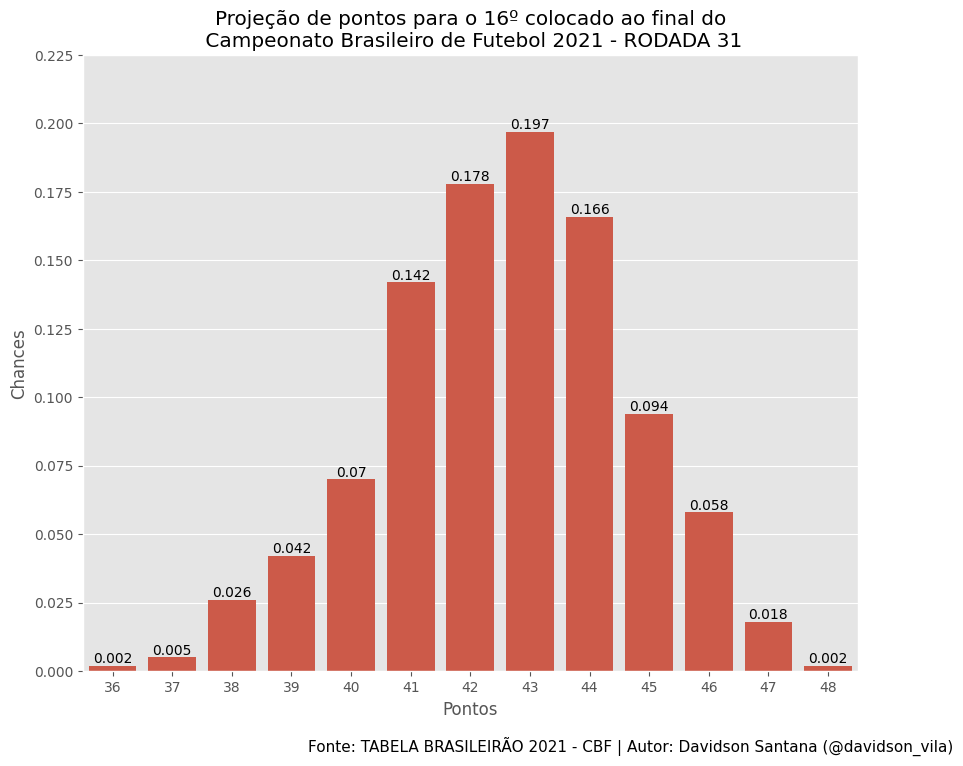

In [ ]:
plt.figure(figsize=(10,8))
g1 = sns.barplot(x=chances_pontos.index, y=chances_pontos)
plt.ylabel('Chances')
plt.yticks(np.arange(0, chances_pontos.max()+0.03, 0.025))
# g1.annotate('25,5%', xy=(45, 0.2551), fontsize=14, xytext=(45, 0.2551))
plt.bar_label(g1.containers[0])
plt.title('Projeção de pontos para o 16º colocado ao final do\n Campeonato Brasileiro de Futebol 2021 - RODADA 31')
plt.figtext(0.35, 0.009,'Fonte: TABELA BRASILEIRÃO 2021 - CBF | Autor: Davidson Santana (@davidson_vila)', fontsize=11)
plt.xlabel('Pontos')
# plt.savefig('./IMAGENS/rodada-32-projecao-pontos-16-colocado-2021.png', format='png')

### ANÁLISES PARA O 1º COLOCADO

In [ ]:
simulacao_campeao = simulacao[simulacao['rank'] == 1]
pontuacao_campeao = simulacao_campeao['pontos'].value_counts()
chances_pontos_campeao = round(pontuacao_campeao/len(simulacao_campeao),4)
chances_pontos_campeao

pontos
73    0.094
75    0.084
74    0.083
76    0.083
77    0.080
71    0.079
72    0.074
70    0.059
79    0.054
78    0.044
69    0.043
80    0.036
81    0.035
68    0.031
82    0.025
67    0.022
83    0.019
66    0.013
84    0.009
85    0.007
65    0.005
86    0.005
87    0.003
89    0.003
88    0.003
63    0.002
62    0.002
90    0.002
92    0.001
Name: count, dtype: float64

Text(0.5, 0, 'Pontos')

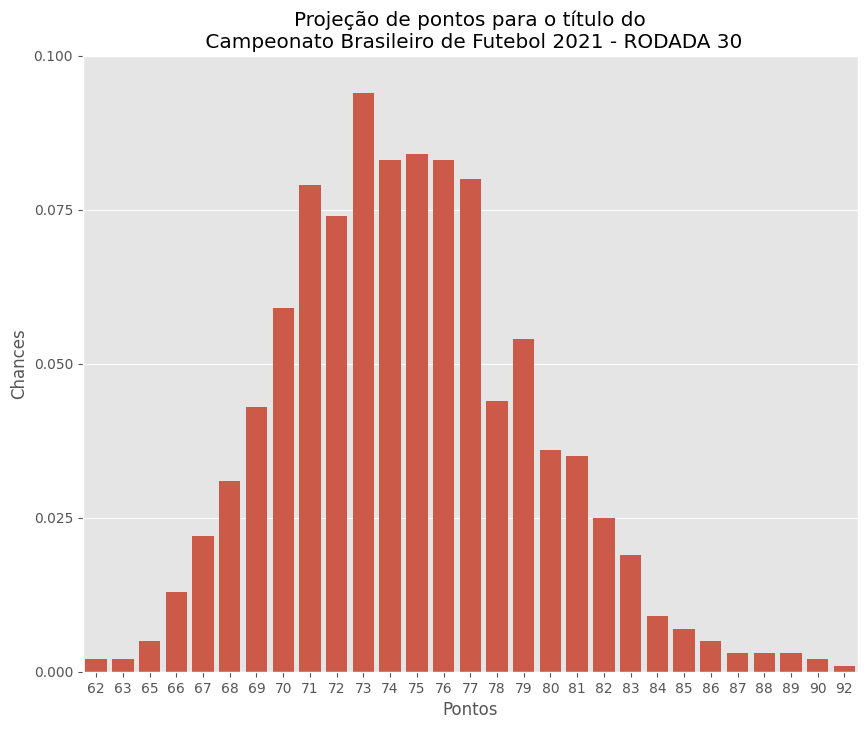

In [ ]:
plt.figure(figsize=(10,8))
g2 = sns.barplot(x=chances_pontos_campeao.index, y=chances_pontos_campeao)
plt.ylabel('Chances')
plt.yticks(np.arange(0, chances_pontos_campeao.max()+0.025, 0.025))
plt.title('Projeção de pontos para o título do\n Campeonato Brasileiro de Futebol 2021 - RODADA 30')
plt.xlabel('Pontos')
# plt.savefig('./IMAGENS/rodada-32-projecao-pontos-campeao-2021.png', format='png')

### ANÁLISES PARA O 4º COLOCADO

In [ ]:
simulacao_campeao = simulacao[simulacao['rank'] == 4]
pontuacao_campeao = simulacao_campeao['pontos'].value_counts()
chances_pontos_campeao = round(pontuacao_campeao/len(simulacao_campeao),4)
chances_pontos_campeao

pontos
63    0.153
62    0.152
64    0.138
61    0.114
60    0.094
65    0.084
59    0.066
66    0.062
67    0.049
58    0.026
68    0.021
69    0.013
57    0.012
71    0.005
56    0.004
70    0.004
55    0.003
Name: count, dtype: float64

Text(0.5, 0, 'Pontos')

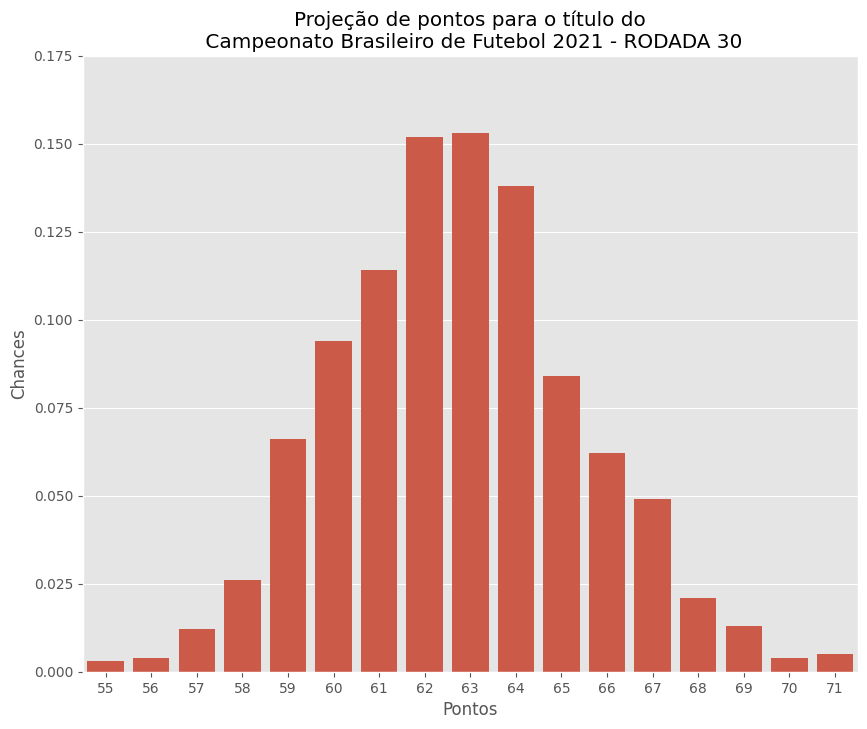

In [ ]:
plt.figure(figsize=(10,8))
g2 = sns.barplot(x=chances_pontos_campeao.index, y=chances_pontos_campeao)
plt.ylabel('Chances')
plt.yticks(np.arange(0, chances_pontos_campeao.max()+0.025, 0.025))
plt.title('Projeção de pontos para o título do\n Campeonato Brasileiro de Futebol 2021 - RODADA 30')
plt.xlabel('Pontos')
# plt.savefig('./IMAGENS/rodada-32-projecao-pontos-campeao-2021.png', format='png')